<a href="https://colab.research.google.com/github/butoialexandra/Realistic-looking-rainfall-forecasts/blob/Alex/verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Verification measures




In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive')

Mounted at /content/drive


In [3]:
!pip install pysteps pyproj properscoring xarray 

     |████████████████████████████████| 440kB 4.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.9MB 17.5MB/s 
Processing /root/.cache/pip/wheels/64/f4/de/9667d84f759289edf5442220997c6d4334637a6bb2a7b90f73/jsmin-2.2.2-cp36-none-any.whl
  Created wheel for pysteps: filename=pysteps-1.3.2-cp36-cp36m-linux_x86_64.whl size=989009 sha256=4738d3fb770671c7f09f6d347aef66ccf08010157a831890e97d2ec339995fef
  Stored in directory: /root/.cache/pip/wheels/b4/2b/6a/0af67d3ebe2cfa02369ba3605e5acd40ea7763f0fe3d4ed751
Successfully built pysteps


In [4]:
!pip install netcdf4

     |████████████████████████████████| 4.3MB 4.7MB/s 
     |████████████████████████████████| 296kB 39.7MB/s 


In [5]:
!pip install zarr

     |████████████████████████████████| 133kB 5.1MB/s 
     |████████████████████████████████| 5.8MB 5.4MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-cp36-none-any.whl size=5037 sha256=3c882b4026876dec0b63961f879e7e05fc3a18a8cb1ec8f156b85ed75f7ec6b3
  Stored in directory: /root/.cache/pip/wheels/1d/d9/58/9808b306744df0208fccc640d3d9952a5bc7468502d42897d5
Successfully built asciitree


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import pyproj
import properscoring as ps
import xarray as xr
from scipy.spatial import cKDTree

In [7]:
combi = xr.open_mfdataset("combiprecip_201805.nc", combine='by_coords') # CombiPrecip
cosmo = xr.open_zarr("cosmoe_prec_201805.zarr") # COSMO-E

Transform coordinate system

In [8]:
# Transform to Swiss coordinate system
src_proj = pyproj.Proj("EPSG:4326") # WSG84
dst_proj = pyproj.Proj("EPSG:21781") # CH1903 / LV03 
src_x = cosmo.lon.values
src_y = cosmo.lat.values
dst_x, dst_y = pyproj.transform(src_proj, dst_proj, src_x, src_y, always_xy=True)
cosmo = cosmo.assign_coords({"chx": (("y", "x"), dst_x) , "chy": (("y", "x"), dst_y)})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


Select the same area for both datasets

In [9]:
pred_points = cosmo.isel(reftime=0, leadtime=1)
chx, chy = pred_points['chx'], pred_points['chy']
# These are the actual predictions (ensemble_cnt, x_len, y_len)
pred_points.PREC.values.shape

(21, 127, 188)

In [10]:
real_points = combi.isel(time=0, dummy=0).sel(chx=chx, chy=chy, method='nearest')
# These are the observations that are closest to our predictions.
# Note that the shape is the same as the shape of predictions
#  with the ensemble dimension removed.
real_points.RR.values.shape

(127, 188)

In [11]:
real_points.RR

<xarray.DataArray 'RR' (y: 127, x: 188)>
dask.array<reshape, shape=(127, 188), dtype=float32, chunksize=(127, 188), chunktype=numpy.ndarray>
Coordinates:
    dummy     float64 1.0
    chx       (y, x) float64 4.495e+05 4.525e+05 ... 8.555e+05 8.575e+05
    chy       (y, x) float64 3.95e+04 3.95e+04 3.95e+04 ... 3.325e+05 3.335e+05
    time      datetime64[ns] 2018-05-01T01:00:00
    lon       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
    lat       (y, x) float32 dask.array<chunksize=(127, 188), meta=np.ndarray>
    leadtime  timedelta64[ns] 01:00:00
    reftime   datetime64[ns] 2018-05-01
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 180 181 182 183 184 185 186 187
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 119 120 121 122 123 124 125 126
Attributes:
    units:         mm
    grid_mapping:  swiss_coordinates
    long_name:     precipitation amount
    grid_name:     swisscors
    version:       no version
    prod_date:     2020-09-15

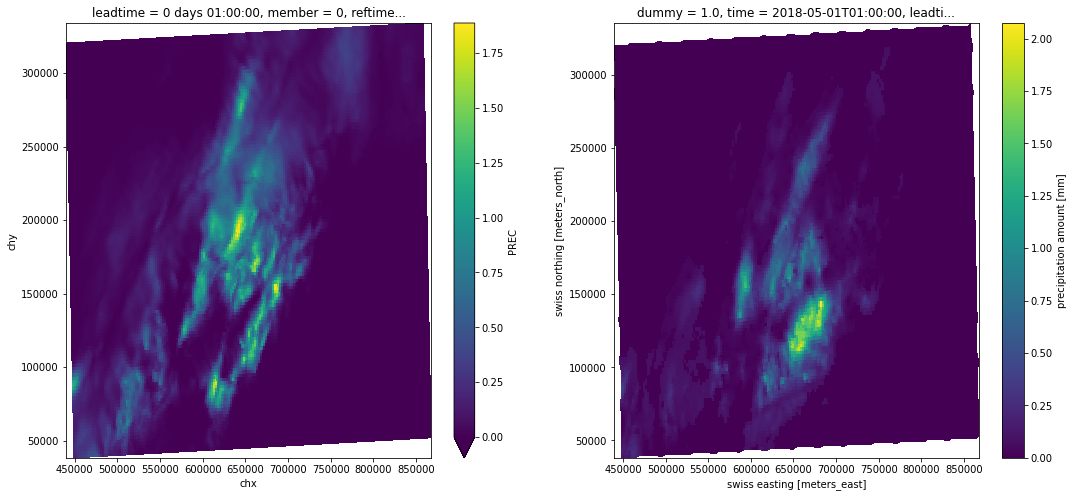

In [12]:
# Plot predictions on the left and observations on the right
fig, axes = plt.subplots(ncols=2, figsize=(18,8))
pred_points.PREC.isel(member=0).plot.pcolormesh("chx", "chy", ax=axes[0], cmap='viridis', vmin=0)
real_points.RR.plot.pcolormesh("chx", "chy", ax=axes[1])

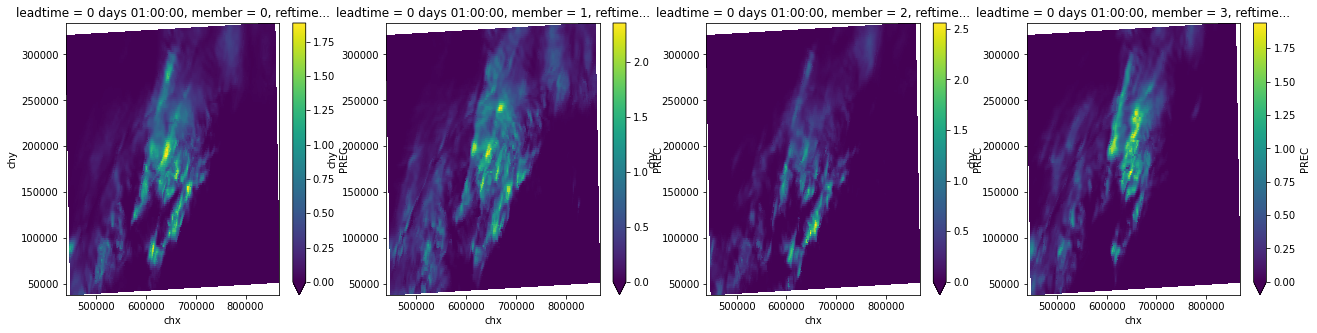

In [13]:
# Plot forecast from multiple members of the ensemble
fig, axes = plt.subplots(ncols=4, figsize=(22,5))
for i in range(4):
  pred_points.PREC.isel(member=i).plot.pcolormesh("chx", "chy", ax=axes[i], cmap='viridis', vmin=0)

Reliability diagram

In [14]:
from pysteps.postprocessing import ensemblestats
from pysteps import verification

Pysteps configuration file found at: /usr/local/lib/python3.6/dist-packages/pysteps/pystepsrc



In [21]:
probs = ensemblestats.excprob(pred_points.PREC, 0.1, ignore_nan=True)
probs.shape

(127, 188)

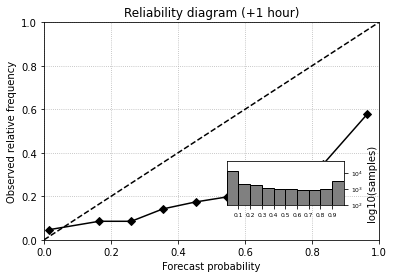

In [22]:
# Plot reliability diagram
reldiag = verification.reldiag_init(0.1)
verification.reldiag_accum(reldiag, probs, real_points.RR.values)
fig, ax = plt.subplots()
verification.plot_reldiag(reldiag, ax)
ax.set_title("Reliability diagram (+1 hour)")
plt.show()

Rank Histogram

In [17]:
n_members = pred_points.PREC.values.shape[0]
n_members

21

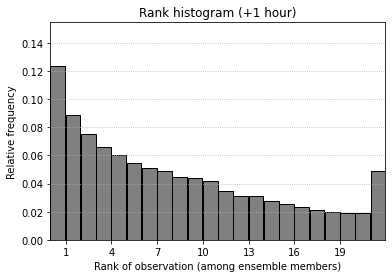

In [23]:
rankhist = verification.rankhist_init(n_members, 0.1)
verification.rankhist_accum(rankhist, pred_points.PREC.values, real_points.RR.values)
fig, ax = plt.subplots()
verification.plot_rankhist(rankhist, ax)
ax.set_title("Rank histogram (+1 hour)")
plt.show()

Continuous Rank Probability Score (CRPS)

In [24]:
crps = verification.probscores.CRPS_init()
verification.probscores.CRPS_accum(crps, pred_points.PREC.values, real_points.RR.values)
verification.probscores.CRPS_compute(crps)

0.06763725465130492

Brier Score

In [20]:
from sklearn.metrics import brier_score_loss

In [28]:
real_points.RR.values.shape, pred_points.PREC.values.shape

((127, 188), (21, 127, 188))

In [29]:
pred_points.PREC.values.transpose(1,2,0).shape

(127, 188, 21)

In [30]:
threshold_scores = ps.threshold_brier_score(real_points.RR.values, pred_points.PREC.values.transpose(1,2,0), threshold=0.1)

In [33]:
threshold_scores.mean()

0.1566902351491778

Ranked Probability Score

In [34]:
def mm_to_categorical(x):
  if x < 0.1:
    return 0
  else:
    if x < 1:
      return 1
    else:
      if x < 5:
        return 2
      else:
        if x < 10:
          return 3
        else:
          return 4

In [35]:
convert_mm_to_categorical = np.vectorize(mm_to_categorical)

In [36]:
obs_categories = convert_mm_to_categorical(real_points.RR.values)
obs_categories.shape

(127, 188)

In [37]:
obs_categories

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
pred_categories = convert_mm_to_categorical(pred_points.PREC.values)
pred_categories.shape

(21, 127, 188)

In [79]:
def RPS(obs_categories, pred_categories, n_categories):
  probs_for_categories = np.zeros((n_categories, obs_categories.shape[0], obs_categories.shape[1]))
  probs_for_observations = np.zeros((n_categories, obs_categories.shape[0], obs_categories.shape[1]))
  for i in range(n_categories):
    probs_for_observations[i,:,:] = (obs_categories == i).astype(float)
    probs_for_categories[i,:,:] = (pred_categories == i).sum(axis=0) / pred_categories.shape[0]

  mse = (probs_for_observations.sum(axis=0) - probs_for_categories.sum(axis=0)) ** 2
  mse = mse.sum() / (mse.size - 1)
  return mse


In [81]:
rps = RPS(obs_categories, pred_categories, 5)
rps

9.809134292669649e-35